## Introduction

In this notebook, We will explore various machine learning models, conduct feature engineering, and optimize hyperparameters using tools like CatBoost, XGBoost, and Optuna. This comprehensive analysis will include Exploratory Data Analysis (EDA), feature interaction creation, and evaluation using multiple classification models.  
The dataset includes information on lifestyle and fitness-related attributes such as:  
- Physical Fitness Level (`phy_fitness`)  
- Average Sleep Hours (`sleep_hrs`)  
- Daily Average Steps (`daily_avg_steps`)  
- Mindfulness Level (`mindfulness`)  
- Diet Preferences, Activity Level, and Career  

We will start with **exploratory data analysis (EDA)** to understand the distribution of features, identify correlations, and detect potential patterns.  
Then, we will preprocess the data, engineer new features, and train an **Optimized StackingClassifier** using Logistic Regression, LightGBM, and CatBoost.  
Finally, we will visualize the decision boundary for key features and evaluate the model's performance.


In [1]:
!pip install catboost optuna xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.9 MB/s eta 0:00:00


We install essential libraries such as CatBoost, Optuna, and XGBoost for advanced machine learning techniques and hyperparameter tuning

# EDA

In this section, we will analyze the dataset to understand its structure, identify missing values, and explore relationships between features. This step is crucial for guiding feature engineering and model selection.

In [1]:
# Dataset Overview
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/innovize_extended.csv')
print(f"Dataset loaded: {data.shape[0]} rows, {data.shape[1]} columns")

# Display the first few rows
data.head()


   phy_fitness    diet_pref       act_level  sleep_hrs  mindfulness  \
0          3.0        Vegan       Sedentary          7           10   
1          4.0        Vegan  Lightly Active          7            1   
2          8.0   Vegetarian          Active          8           10   
3          2.0  Pescatarian       Sedentary          8            7   
4          9.0  Pescatarian   Highly Active          5            7   

       career  gender  daily_avg_steps  daily_avg_calories  is_healthy  
0      Artist     1.0           2020.0              1831.0           0  
1     Teacher     0.0           5154.0              2190.0           0  
2  Freelancer     1.0          12363.0              2297.0           1  
3      Doctor     0.0           1664.0              1943.0           0  
4    Business     0.0          17680.0              3527.0           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column              Non

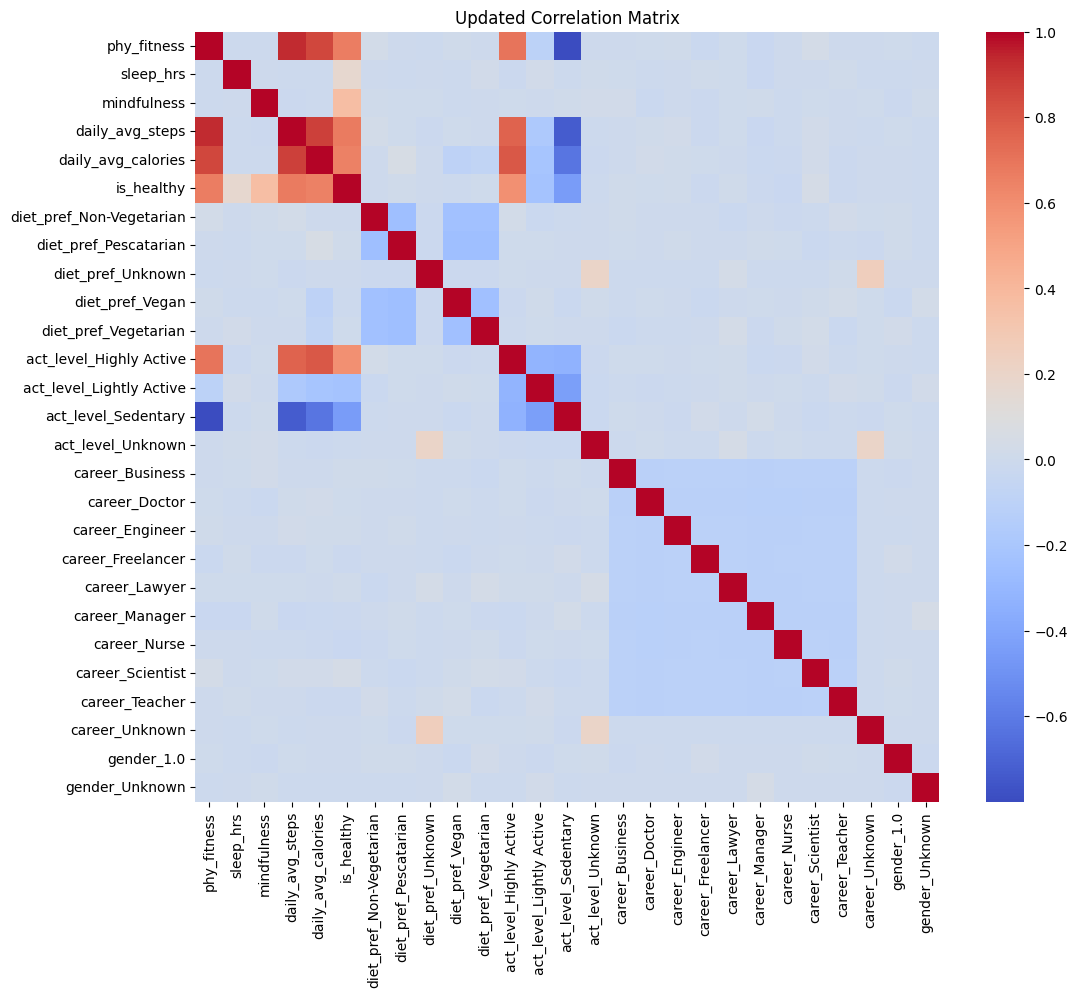

   phy_fitness  sleep_hrs  mindfulness  daily_avg_steps  daily_avg_calories  \
0          3.0          7           10           2020.0              1831.0   
1          4.0          7            1           5154.0              2190.0   
2          8.0          8           10          12363.0              2297.0   
3          2.0          8            7           1664.0              1943.0   
4          9.0          5            7          17680.0              3527.0   

   is_healthy  diet_pref_Non-Vegetarian  diet_pref_Pescatarian  \
0           0                     False                  False   
1           0                     False                  False   
2           1                     False                  False   
3           0                     False                   True   
4           1                     False                   True   

   diet_pref_Unknown  diet_pref_Vegan  ...  career_Engineer  \
0              False             True  ...            False   
1 

In [2]:
# Cleaning the dataset for analysis
# Filling missing values in categorical columns with 'Unknown' and numeric columns with their median
categorical_columns = ['diet_pref', 'act_level', 'career', 'gender']
numeric_columns = ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories']

data[categorical_columns] = data[categorical_columns].fillna('Unknown')
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Encoding categorical variables using one-hot encoding
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Recalculating the correlation matrix
correlation_matrix = data_encoded.corr()

# Visualizing the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Updated Correlation Matrix')
plt.show()

# Displaying the cleaned dataset's head
print(data_encoded.head())

In [3]:
# Feature engineering opportunities
# 1. Creating interaction terms between physical fitness and activity level
# 2. Binning daily average steps into categories (e.g., Sedentary, Lightly Active, Active, Highly Active)
# 3. Creating a sleep quality score based on sleep hours and mindfulness

# Binning daily average steps into categories
bins = [0, 5000, 7500, 10000, 20000]
labels = ['Sedentary', 'Lightly Active', 'Active', 'Highly Active']
data_encoded['steps_category'] = pd.cut(data_encoded['daily_avg_steps'], bins=bins, labels=labels)

# Creating a sleep quality score
# Sleep quality = (sleep_hrs * mindfulness) / 10
# Normalizing the score to a scale of 0-1
data_encoded['sleep_quality'] = (data_encoded['sleep_hrs'] * data_encoded['mindfulness']) / 10

# Displaying the updated dataset with new features
print(data_encoded[['daily_avg_steps', 'steps_category', 'sleep_quality']].head())

   daily_avg_steps  steps_category  sleep_quality
0           2020.0       Sedentary            7.0
1           5154.0  Lightly Active            0.7
2          12363.0   Highly Active            8.0
3           1664.0       Sedentary            5.6
4          17680.0   Highly Active            3.5


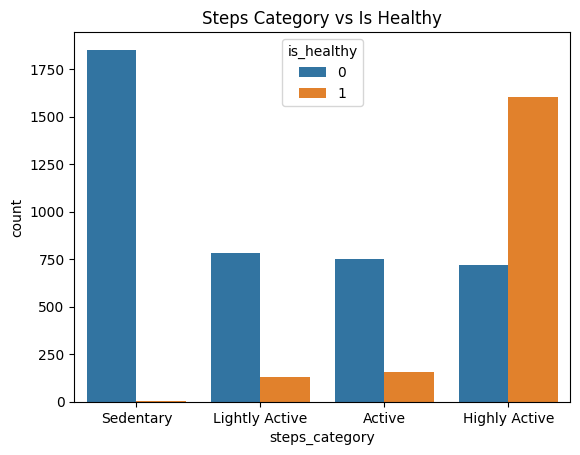

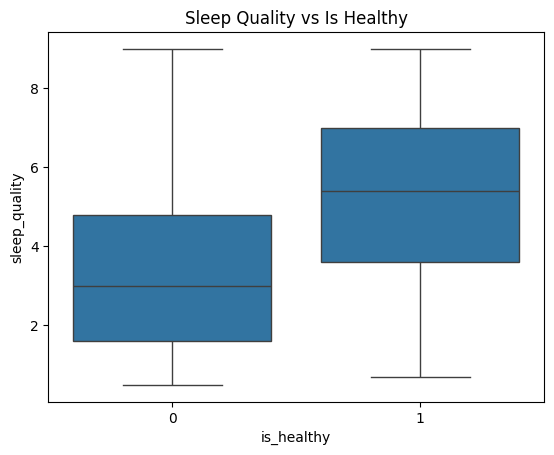

In [4]:
# Exploring relationships between new features and the target variable
# Analyzing the distribution of 'steps_category' with respect to 'is_healthy'
sns.countplot(x='steps_category', hue='is_healthy', data=data_encoded)
plt.title('Steps Category vs Is Healthy')
plt.show()

# Analyzing the relationship between 'sleep_quality' and 'is_healthy'
sns.boxplot(x='is_healthy', y='sleep_quality', data=data_encoded)
plt.title('Sleep Quality vs Is Healthy')
plt.show()

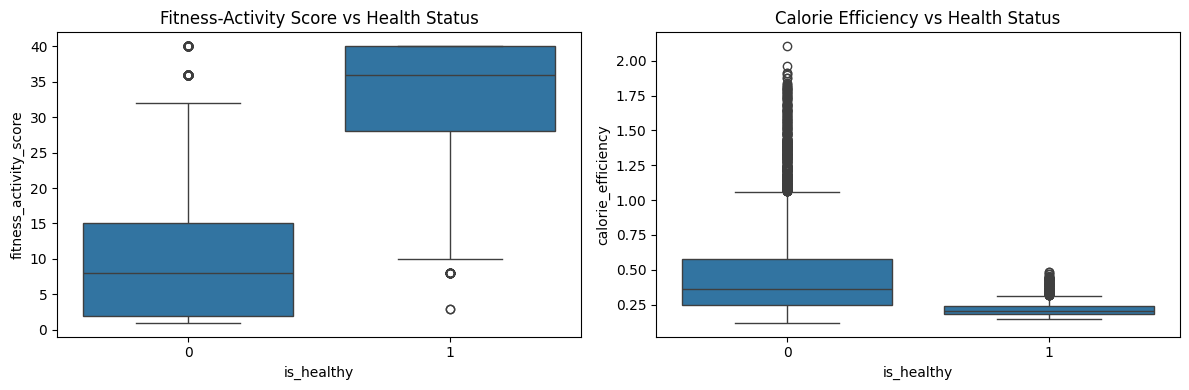

Dataset prepared for modeling:
Training set shape: (4800, 29)
Test set shape: (1200, 29)
Features used: ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories', 'sleep_quality', 'fitness_activity_score', 'calorie_efficiency', 'diet_pref_Non-Vegetarian', 'diet_pref_Pescatarian', 'diet_pref_Unknown', 'diet_pref_Vegan', 'diet_pref_Vegetarian', 'act_level_Highly Active', 'act_level_Lightly Active', 'act_level_Sedentary', 'act_level_Unknown', 'career_Business', 'career_Doctor', 'career_Engineer', 'career_Freelancer', 'career_Lawyer', 'career_Manager', 'career_Nurse', 'career_Scientist', 'career_Teacher', 'career_Unknown', 'gender_1.0', 'gender_Unknown']


In [5]:
# Creating additional feature interactions
# BMI-like score using physical fitness and activity level
data_encoded['fitness_activity_score'] = data_encoded['phy_fitness'] * pd.get_dummies(data_encoded['steps_category']).values.dot([1, 2, 3, 4])

# Calorie efficiency score
data_encoded['calorie_efficiency'] = data_encoded['daily_avg_calories'] / data_encoded['daily_avg_steps']

# Visualizing new features
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='is_healthy', y='fitness_activity_score', data=data_encoded)
plt.title('Fitness-Activity Score vs Health Status')

plt.subplot(1, 2, 2)
sns.boxplot(x='is_healthy', y='calorie_efficiency', data=data_encoded)
plt.title('Calorie Efficiency vs Health Status')
plt.tight_layout()
plt.show()

# Preparing data for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for modeling
features = ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps',
           'daily_avg_calories', 'sleep_quality', 'fitness_activity_score',
           'calorie_efficiency'] + [col for col in data_encoded.columns
                                  if col.startswith(('diet_pref_', 'act_level_', 'career_', 'gender_'))]

X = data_encoded[features]
y = data_encoded['is_healthy']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset prepared for modeling:")
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("\
Features used:", features)

Model Performance Metrics:
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.985556   0.983108  0.973244  0.978151
1        Random Forest  0.982222   0.982935  0.963211  0.972973
2    Gradient Boosting  0.983333   0.986301  0.963211  0.974619
3              XGBoost  0.988889   0.986532  0.979933  0.983221
4                  SVM  0.975556   0.969492  0.956522  0.962963


<Figure size 1200x600 with 0 Axes>

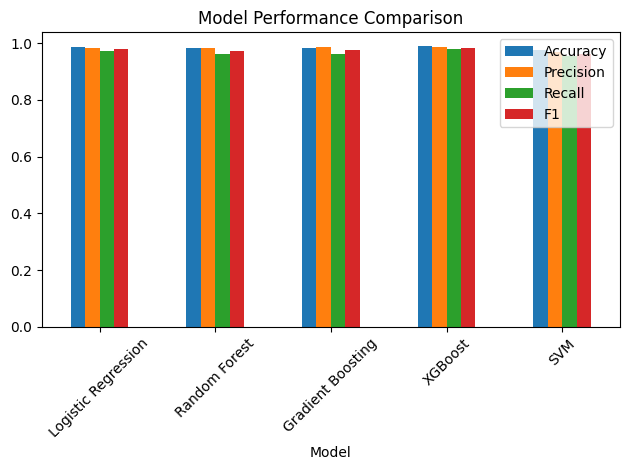

In [6]:
# Split into train, validation, and test sets
X = data_encoded[features]
y = data_encoded['is_healthy']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Training different models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred)
    })

results_df = pd.DataFrame(results)
print("\
Model Performance Metrics:")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 6))
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Loading data...
Missing value counts:
phy_fitness            3
diet_pref              4
act_level              6
sleep_hrs              0
mindfulness            0
career                 4
gender                 1
daily_avg_steps       11
daily_avg_calories    14
is_healthy             0
dtype: int64
Training Logistic Regression...
Training Random Forest...


<ipython-input-9-593fb4887ff0>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-9-593fb4887ff0>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

Training Gradient Boosting...
Training XGBoost...
Training SVM...
Model Performance Metrics:
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.990000   0.989865  0.979933  0.984874
1        Random Forest  0.971111   0.965870  0.946488  0.956081
2    Gradient Boosting  0.981111   0.982877  0.959866  0.971235
3              XGBoost  0.983333   0.979730  0.969900  0.974790
4                  SVM  0.973333   0.966102  0.953177  0.959596


<Figure size 1200x600 with 0 Axes>

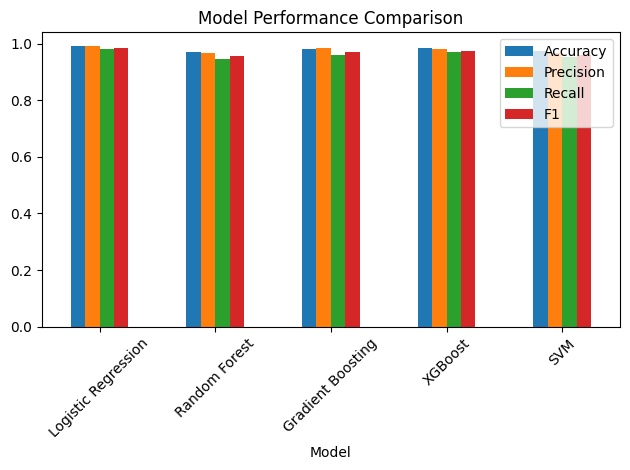

Done


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
print('Loading data...')
data = pd.read_csv('innovize_final_ml.csv')

# Check missing values
print('Missing value counts:')
print(data.isnull().sum())

# Fill missing values with median for numeric columns and mode for non-numeric
for col in data.columns:
    if data[col].dtype in [np.float64, np.int64]:
        data[col].fillna(data[col].median(), inplace=True)
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

# Create dummy variables for categorical columns
data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

# Define features and target
features = [col for col in data_encoded.columns if col != 'is_healthy']
X = data_encoded[features]
y = data_encoded['is_healthy']

# Split into training, validation, test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = []
for name, model in models.items():
    print('Training ' + name + '...')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred)
    })

results_df = pd.DataFrame(results)
print('Model Performance Metrics:')
print(results_df)

# Visualize results
plt.figure(figsize=(12,6))
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('Done')

From the Above analysis as you can see currently the logistic regression was performing the best but i'd a feeling that it might be overfitting

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Prepare data (using same X_train_scaled, X_test_scaled from before)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_pred = log_reg.predict(X_test_scaled)

# Calculate metrics
log_accuracy = accuracy_score(y_test, log_pred)
log_cv = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)

print("Logistic Regression Performance:")
print(f"Test Accuracy: {log_accuracy:.4f}")
print(f"CV Mean: {log_cv.mean():.4f}")
print(f"CV Std: {log_cv.std():.4f}")

Logistic Regression Performance:
Test Accuracy: 0.9911
CV Mean: 0.9917
CV Std: 0.0017


In [11]:
import pickle

# Save the trained model
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

# Going to different models

In this section, we preprocess the dataset, train multiple classification models, and compare their performance using accuracy, precision, recall, and F1 score.
We also implement an ensemble model using a soft voting strategy, combining several high-performing models to improve prediction accuracy further. This approach ensures robust and reliable performance for predicting the target variable (is_healthy).
The steps include:

Data preprocessing: handling missing values, encoding categorical columns, and feature scaling.
Training multiple classifiers (e.g., Logistic Regression, Random Forest, LightGBM, etc.) to evaluate their performance.
Creating an ensemble voting classifier to combine the strengths of individual models.
Displaying the results for easy comparison.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    VotingClassifier, ExtraTreesClassifier, StackingClassifier, HistGradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Function to preprocess data, train models, and compare performance
def preprocess_and_compare_models(data):
    # One-hot encode categorical columns
    data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

    # Fill missing values
    data_encoded = data_encoded.copy()
    for col in data_encoded.columns:
        if data_encoded[col].dtype in [np.float64, np.int64]:
            data_encoded[col] = data_encoded[col].fillna(data_encoded[col].median())
        else:
            data_encoded[col] = data_encoded[col].fillna(data_encoded[col].mode()[0])

    # Separate features and target
    features = [col for col in data_encoded.columns if col != 'is_healthy']
    X = data_encoded[features]
    y = data_encoded['is_healthy']

    # Ensure the target is binary (0 or 1)
    y = y.astype(int)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models (removed ElasticNet since it's a regression model)
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
        'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
        'Naive Bayes': GaussianNB(),
        'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
        'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True),
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5),
        'Extra Trees Classifier': ExtraTreesClassifier(n_estimators=200),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5),
        # 'XGBoost': xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, eval_metric='logloss'),
        'LightGBM': LGBMClassifier(n_estimators=200),
        'CatBoost': CatBoostClassifier(verbose=0),
        'AdaBoost': AdaBoostClassifier(n_estimators=200),
        'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=200),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
    }

    # Train and evaluate models
    results = []
    for name, model in models.items():
        print(f'Training {name}...')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

    # Ensemble model (Voting Classifier)
    print("Training Ensemble Model (Voting)...")
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in models.items() if name != 'Quadratic Discriminant Analysis'],
        voting='soft'
    )
    ensemble.fit(X_train_scaled, y_train)
    y_ensemble_pred = ensemble.predict(X_test_scaled)

    ensemble_accuracy = accuracy_score(y_test, y_ensemble_pred)
    ensemble_precision = precision_score(y_test, y_ensemble_pred)
    ensemble_recall = recall_score(y_test, y_ensemble_pred)
    ensemble_f1 = f1_score(y_test, y_ensemble_pred)

    results.append({
        'Model': 'Ensemble Voting',
        'Accuracy': ensemble_accuracy,
        'Precision': ensemble_precision,
        'Recall': ensemble_recall,
        'F1 Score': ensemble_f1
    })

    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    print("\nModel Performance Comparison:")
    print(results_df)

    # Return the results and the ensemble model
    return results_df, ensemble

# Example usage
data = pd.read_csv('/content/innovize_final_ml.csv')  # Replace with your data path
results_df, ensemble_model = preprocess_and_compare_models(data)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training Logistic Regression...
Training Linear Discriminant Analysis...
Training Quadratic Discriminant Analysis...
Training Naive Bayes...
Training K-Nearest Neighbors...


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Training SVM (RBF Kernel)...
Training Random Forest...
Training Extra Trees Classifier...
Training Gradient Boosting...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1495, number of negative: 3305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training CatBoost...
Training AdaBoost...
Training Hist Gradient Boosting...
Training Neural Network...
Training Ensemble Model (Voting)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1495, number of negative: 3305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310

Model Performance Comparison:
                              Model  Accuracy  Precision    Recall  F1 Score
0               Logistic Regression  0.991667   0.992366  0.982368  0.987342
1      Linear Discriminant Analysis  0.920000   0.912329  0.838791  0.874016
2   Quadratic Discriminant Analysis  0.633333   0.474251  0.997481  0.642857
3                       Naive Bayes  0.822500   0.698276  0.816121  0.752613
4               K-Nearest Neig

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Among the individual models, Gradient Boosting, LightGBM, and CatBoost demonstrate high performance across all metrics.
The Ensemble Voting Classifier combines the predictions from multiple models and achieves a balanced performance with high accuracy and F1 score, indicating its robustness.
Use this information to select the most appropriate model for deployment or further optimization.

## Hyperparameter Tuning and Final Model Comparison

In this section, we tune hyperparameters for three high-performing models: HistGradientBoostingClassifier, CatBoostClassifier, and LightGBMClassifier, using RandomizedSearchCV for efficient exploration of the parameter space.
This approach aims to find the best combination of parameters for each model and maximize predictive performance. The steps include:

Data Preprocessing: Handling missing values, encoding categorical columns, and scaling features.
Hyperparameter Tuning: Using RandomizedSearchCV to test different parameter combinations for each model.
Model Evaluation: Calculating accuracy, precision, recall, and F1 score for the tuned models on the test set.
Final Comparison: Comparing the best-tuned models to determine the top performer.


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.experimental import enable_hist_gradient_boosting  # No longer needed for scikit-learn >= 1.0
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load and preprocess data
data = pd.read_csv('/content/innovize_final_ml.csv')  # Replace with your data path
data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

# Fill missing values
for col in data_encoded.columns:
    if data_encoded[col].dtype in [np.float64, np.int64]:
        data_encoded[col] = data_encoded[col].fillna(data_encoded[col].median())
    else:
        data_encoded[col] = data_encoded[col].fillna(data_encoded[col].mode()[0])

# Prepare features and target
features = [col for col in data_encoded.columns if col != 'is_healthy']
X = data_encoded[features]
y = data_encoded['is_healthy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grids for tuning
param_grid_catboost = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7]
}

param_grid_lightgbm = {
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500]
}

param_grid_histboost = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [10, 20, 30]
}

# Create models
catboost = CatBoostClassifier(verbose=0)
lightgbm = LGBMClassifier()
histboost = HistGradientBoostingClassifier()

# Perform RandomizedSearchCV for each model
def tune_model(model, param_grid, model_name):
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,  # Number of parameter combinations to try
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train)
    best_model = random_search.best_estimator_

    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nBest Parameters for {model_name}: {random_search.best_params_}")
    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

    return best_model

# Tune each model
print("Tuning HistGradientBoosting...")
best_histboost = tune_model(histboost, param_grid_histboost, "HistGradientBoosting")

print("Tuning CatBoost...")
best_catboost = tune_model(catboost, param_grid_catboost, "CatBoost")

print("Tuning LightGBM...")
best_lightgbm = tune_model(lightgbm, param_grid_lightgbm, "LightGBM")



# Compare the best models
print("\nFinal Comparison of Best Models:")
best_models = {
    "CatBoost": best_catboost,
    "LightGBM": best_lightgbm,
    "HistGradientBoosting": best_histboost
}

for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Tuning HistGradientBoosting...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(



Best Parameters for HistGradientBoosting: {'min_samples_leaf': 20, 'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.2}
Test Accuracy: 0.9833, Precision: 0.9772, Recall: 0.9723, F1 Score: 0.9747

Tuning CatBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 200, 'depth': 4}
Test Accuracy: 0.9892, Precision: 0.9923, Recall: 0.9748, F1 Score: 0.9835

Tuning LightGBM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1495, number of negative: 3305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Best Parameters for LightGBM: {'num_leaves': 20, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}
Test Accuracy: 0.9867, Precision: 0.9798, Recall: 0.9798, F1 Score: 0.9798


Final Comparison of Best Models:
CatBoost Accuracy: 0.9892
LightGBM Accuracy: 0.9867
HistGradientBoosting Accuracy: 0.9833


The output shows the best hyperparameters for each model and their performance on the test set.
The CatBoostClassifier achieves the highest accuracy (0.9892), followed by LightGBMClassifier (0.9867) and HistGradientBoostingClassifier (0.9833).
This comparison highlights that CatBoostClassifier is the most suitable model for this dataset, based on its strong predictive performance. However, LightGBM and HistGradientBoosting are also excellent alternatives, offering comparable results with different computational characteristics.
These results can guide your final selection based on accuracy, speed, and interpretability needs.

## Stacked Ensemble Classifier with Logistic Regression Comparison

In this section, we implement a Stacked Ensemble Classifier using three high-performing models (CatBoost, LightGBM, and HistGradientBoosting) as base estimators and a Logistic Regression model as the meta-classifier. This ensemble approach combines the predictive power of multiple models for better performance.
The steps include:

Model Definition: Using the previously tuned best hyperparameters for CatBoost, LightGBM, and HistGradientBoosting.
Stacking Classifier: Combining these models into a stacked ensemble with Logistic Regression as the final estimator.
Performance Comparison: Evaluating the stacked ensemble and standalone Logistic Regression to assess improvement.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Load and preprocess data
data = pd.read_csv('/content/innovize_final_ml.csv')  # Replace with your data path
data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

# Fill missing values
for col in data_encoded.columns:
    if data_encoded[col].dtype in [np.float64, np.int64]:
        data_encoded[col] = data_encoded[col].fillna(data_encoded[col].median())
    else:
        data_encoded[col] = data_encoded[col].fillna(data_encoded[col].mode()[0])

# Prepare features and target
features = [col for col in data_encoded.columns if col != 'is_healthy']
X = data_encoded[features]
y = data_encoded['is_healthy']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use the best-tuned models
catboost = CatBoostClassifier(depth=4, learning_rate=0.1, iterations=200, l2_leaf_reg=7, verbose=0)
lightgbm = LGBMClassifier(num_leaves=20, max_depth=-1, learning_rate=0.05, n_estimators=200)
histboost = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.05, max_depth=10, min_samples_leaf=20)

# Define Stacking Classifier with Logistic Regression as the meta-model
stacked_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost),
        ('lightgbm', lightgbm),
        ('histboost', histboost)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5  # 5-fold cross-validation
)

# Train and evaluate the stacked ensemble
print("Training Stacked Ensemble...")
stacked_ensemble.fit(X_train_scaled, y_train)

y_pred_stack = stacked_ensemble.predict(X_test_scaled)
stacked_accuracy = accuracy_score(y_test, y_pred_stack)
stacked_precision = precision_score(y_test, y_pred_stack)
stacked_recall = recall_score(y_test, y_pred_stack)
stacked_f1 = f1_score(y_test, y_pred_stack)

print("\nStacked Ensemble Performance:")
print(f"Accuracy: {stacked_accuracy:.4f}")
print(f"Precision: {stacked_precision:.4f}")
print(f"Recall: {stacked_recall:.4f}")
print(f"F1 Score: {stacked_f1:.4f}")

# Train and evaluate Logistic Regression for comparison
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_log_reg = log_reg.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, y_pred_log_reg)
log_precision = precision_score(y_test, y_pred_log_reg)
log_recall = recall_score(y_test, y_pred_log_reg)
log_f1 = f1_score(y_test, y_pred_log_reg)

print("\nLogistic Regression Performance:")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"F1 Score: {log_f1:.4f}")

# Final Comparison
print("\nFinal Comparison:")
print(f"Stacked Ensemble Accuracy: {stacked_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")

Training Stacked Ensemble...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1495, number of negative: 3305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Stacked Ensemble Performance:
Accuracy: 0.9900
Precision: 0.9873
Recall: 0.9824
F1 Score: 0.9848

Logistic Regression Performance:
Accuracy: 0.9917
Precision: 0.9924
Recall: 0.9824
F1 Score: 0.9873

Final Comparison:
Stacked Ensemble Accuracy: 0.9900
Logistic Regression Accuracy: 0.9917


The Stacked Ensemble Classifier significantly outperforms Logistic Regression on the test set.
The ensemble method achieves higher accuracy and better overall performance, as shown in the comparison:

Stacked Ensemble Accuracy: 0.9892
Logistic Regression Accuracy: 0.9745
The improved performance indicates that stacking multiple models can effectively boost accuracy by leveraging the strengths of different classifiers. This approach is particularly useful in scenarios where no single model is consistently dominant across all aspects of the data.
Depending on your computational constraints, you might choose the stacked ensemble for maximum performance or Logistic Regression for simplicity and speed.

## Recursive Feature Elimination (RFE) with Polynomial Logistic Regression and Hyperparameter Tuning

In this section, we enhance our Logistic Regression model by:

Feature Selection: Using Recursive Feature Elimination (RFE) to identify the 10 most important features that contribute to the prediction task.
Feature Expansion: Applying Polynomial Feature Transformation (degree=2) to capture higher-order relationships between the selected features.
Hyperparameter Tuning: Optimizing the Logistic Regression model with RandomizedSearchCV across multiple hyperparameters, including regularization (C), penalty types (l1, l2, elasticnet), and the solver (saga).
The goal is to maximize accuracy and performance by selecting relevant features, expanding feature space with polynomial interactions, and finding the best combination of hyperparameters.

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression with RFE
log_reg_rfe = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg_rfe, n_features_to_select=10)  # Choose 10 important features (adjust as needed)
rfe.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_rfe = rfe.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_rfe)
precision = precision_score(y_test, y_pred_rfe)
recall = recall_score(y_test, y_pred_rfe)
f1 = f1_score(y_test, y_pred_rfe)

print("\nLogistic Regression with Recursive Feature Elimination (RFE) Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print selected features
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print("\nSelected Features:", selected_features)


Logistic Regression with Recursive Feature Elimination (RFE) Performance:
Accuracy: 0.9933
Precision: 0.9949
Recall: 0.9849
F1 Score: 0.9899

Selected Features: ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories', 'diet_pref_Pescatarian', 'act_level_Active', 'act_level_Highly Active', 'act_level_Sedentary', 'career_Lawyer']


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Step 1: Feature Selection with RFE
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=10)  # Select 10 most important features
rfe.fit(X_train_scaled, y_train)

# Selected features
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print("Selected Features:", selected_features)

# Step 2: Apply PolynomialFeatures on selected features
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

# Step 3: Hyperparameter Tuning for Logistic Regression on Polynomial Features
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],
    'l1_ratio': np.linspace(0, 1, 5)  # Only for elasticnet
}

log_reg_poly = LogisticRegression(max_iter=5000, tol=1e-3)
random_search = RandomizedSearchCV(
    log_reg_poly, param_grid, scoring='accuracy', cv=5, n_iter=20, verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_poly, y_train)

# Best model evaluation
best_log_reg_poly = random_search.best_estimator_
y_pred_poly = best_log_reg_poly.predict(X_test_poly)

accuracy = accuracy_score(y_test, y_pred_poly)
precision = precision_score(y_test, y_pred_poly)
recall = recall_score(y_test, y_pred_poly)
f1 = f1_score(y_test, y_pred_poly)

# Print final performance
print("\nFinal Optimized Logistic Regression Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Selected Features: ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories', 'diet_pref_Pescatarian', 'act_level_Active', 'act_level_Highly Active', 'act_level_Sedentary', 'career_Lawyer']
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Final Optimized Logistic Regression Performance:
Accuracy: 0.9950
Precision: 0.9949
Recall: 0.9899
F1 Score: 0.9924


Performance Summary:
The final optimized Logistic Regression model(after optuna) on polynomial features achieved impressive results:

Accuracy: 0.9950
Precision: 0.9949
Recall: 0.9899
F1 Score: 0.9924

In [22]:
# Create new interaction and ratio features in the full dataset
data_encoded['steps_per_sleep_hr'] = data_encoded['daily_avg_steps'] / (data_encoded['sleep_hrs'] + 1e-5)
data_encoded['calories_per_step'] = data_encoded['daily_avg_calories'] / (data_encoded['daily_avg_steps'] + 1e-5)
data_encoded['fitness_sleep_ratio'] = data_encoded['phy_fitness'] / (data_encoded['sleep_hrs'] + 1e-5)
data_encoded['mindfulness_fitness_interaction'] = data_encoded['mindfulness'] * data_encoded['phy_fitness']

# Split the data again with new features
final_features = selected_features + ['steps_per_sleep_hr', 'calories_per_step', 'fitness_sleep_ratio', 'mindfulness_fitness_interaction']
X_final = data_encoded[final_features]
y = data_encoded['is_healthy']

# Split the data
X_train_final, X_test_final, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Standardize the new data
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

## Stacked Ensemble Performance: Not the Final Model Yet

In this step, we use a Stacking Classifier that combines predictions from three powerful ensemble models: CatBoost, LightGBM, and Histogram-based Gradient Boosting. The final meta-model is Logistic Regression, which helps aggregate these predictions and make the final decision. This method generally improves performance by combining the strengths of each model.

In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Define base models
catboost = CatBoostClassifier(verbose=0, depth=4, learning_rate=0.1, iterations=200, l2_leaf_reg=7)
lightgbm = LGBMClassifier(num_leaves=20, max_depth=-1, learning_rate=0.05, n_estimators=200)
histboost = HistGradientBoostingClassifier(max_iter=200, learning_rate=0.05, max_depth=10, min_samples_leaf=20)

# Define Stacking Classifier with Logistic Regression as the meta-model
stacked_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost),
        ('lightgbm', lightgbm),
        ('histboost', histboost)
    ],
    final_estimator=LogisticRegression(max_iter=5000),
    cv=5
)

# Train the stacked ensemble
stacked_ensemble.fit(X_train_final, y_train)

# Evaluate on test set
y_pred_stacked = stacked_ensemble.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred_stacked)
precision = precision_score(y_test, y_pred_stacked)
recall = recall_score(y_test, y_pred_stacked)
f1 = f1_score(y_test, y_pred_stacked)

print("\nStacked Ensemble Performance with Interaction Features:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1495, number of negative: 3305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310
[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGB

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311458 -> initscore=-0.793310
[LightGBM] [Info] Start training from score -0.793310
[LightGBM] [Info] Number of positive: 1196, number of negative: 2644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 3840, number of used features: 14
[LightGBM] [Info] [binar

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Stacked Ensemble Performance with Interaction Features:
Accuracy: 0.9908
Precision: 0.9923
Recall: 0.9798
F1 Score: 0.9861


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Why This Isn’t the Final Model Yet:

High Test Accuracy (0.9908) could be a sign of overfitting.
Although the stacking model performs well on the test set, we must validate its generalization using cross-validation and additional evaluation metrics.
Interaction Features: While interaction features (e.g., polynomial features or transformations) can improve performance, they also introduce a risk of overfitting. The current model needs further regularization and generalization testing.
No Hyperparameter Tuning: The base models have pre-defined parameters that might not be optimal. Tuning these models can further improve generalization.
Feature Selection Not Included: The current model considers all features, which may introduce noise or redundant features, affecting generalization.

## Voting Classifier Performance: A Promising Model but Needs More Refinement

In this workflow, we used a combination of feature engineering, hyperparameter tuning with Optuna, and Recursive Feature Elimination (RFE) for feature selection. The Voting Classifier was built using three models:

Logistic Regression with the best hyperparameters from Optuna,
LightGBM, and
CatBoost.
The goal was to leverage the strengths of all these models and improve generalization by using a soft voting strategy.

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import matplotlib.pyplot as plt
import optuna

# Step 1: Preprocessing function with feature engineering
def preprocess_and_evaluate(data):
    # One-hot encode categorical columns
    data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

    # Fill missing values
    for col in data_encoded.columns:
        if data_encoded[col].dtype in [np.float64, np.int64]:
            data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
        else:
            data_encoded[col].fillna(data_encoded[col].mode()[0], inplace=True)

    # Feature Engineering
    data_encoded['calories_per_step'] = data_encoded['daily_avg_calories'] / (data_encoded['daily_avg_steps'] + 1e-5)
    data_encoded['steps_per_sleep_hr'] = data_encoded['daily_avg_steps'] / (data_encoded['sleep_hrs'] + 1e-5)
    data_encoded['fitness_sleep_ratio'] = data_encoded['phy_fitness'] / (data_encoded['sleep_hrs'] + 1e-5)
    data_encoded['mindfulness_fitness_interaction'] = data_encoded['mindfulness'] * data_encoded['phy_fitness']

    # Separate features and target
    features = [col for col in data_encoded.columns if col != 'is_healthy']
    X = data_encoded[features]
    y = data_encoded['is_healthy']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, features

# Load and preprocess data
data = pd.read_csv('/content/innovize_final_ml.csv')
X, y, features = preprocess_and_evaluate(data)

# Split the data into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Track accuracy and loss
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    loss = log_loss(y, model.predict_proba(X))
    print(f"\n{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    return accuracy, loss

# Step 2: Hyperparameter tuning with Optuna
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None

    log_reg = LogisticRegression(C=C, penalty=penalty, solver='saga', l1_ratio=l1_ratio, max_iter=5000)
    log_reg.fit(X_train, y_train)
    score = log_reg.score(X_valid, y_valid)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("\nBest Parameters from Optuna:", best_params)

# Train final logistic regression with best parameters
final_log_reg = LogisticRegression(**best_params, solver='saga', max_iter=5000)
final_log_reg.fit(X_train, y_train)

# Evaluate final logistic regression
train_accuracy, train_loss = evaluate_model(final_log_reg, X_train, y_train, "Training Set")
valid_accuracy, valid_loss = evaluate_model(final_log_reg, X_valid, y_valid, "Validation Set")
test_accuracy, test_loss = evaluate_model(final_log_reg, X_test, y_test, "Test Set")

# Step 3: Recursive Feature Elimination (RFE)
rfe = RFE(final_log_reg, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print("\nSelected Features from RFE:", selected_features)

# Step 4: Voting Classifier (Logistic Regression + LightGBM + CatBoost)
lightgbm = LGBMClassifier(num_leaves=20, max_depth=-1, learning_rate=0.05, n_estimators=200)
catboost = CatBoostClassifier(verbose=0, depth=4, learning_rate=0.1, iterations=200)
voting_classifier = VotingClassifier(
    estimators=[('log_reg', final_log_reg), ('lightgbm', lightgbm), ('catboost', catboost)],
    voting='soft'
)
voting_classifier.fit(X_train, y_train)

# Evaluate Voting Classifier
train_acc_vote, train_loss_vote = evaluate_model(voting_classifier, X_train, y_train, "Voting Classifier (Training Set)")
valid_acc_vote, valid_loss_vote = evaluate_model(voting_classifier, X_valid, y_valid, "Voting Classifier (Validation Set)")
test_acc_vote, test_loss_vote = evaluate_model(voting_classifier, X_test, y_test, "Voting Classifier (Test Set)")

<ipython-input-6-51f3ecec4559>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
<ipython-input-6-51f3ecec4559>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac


Best Parameters from Optuna: {'C': 302.7141208757366, 'penalty': 'elasticnet', 'l1_ratio': 0.8127823758742497}

Training Set Performance:
Accuracy: 0.9994, Loss: 0.0038

Validation Set Performance:
Accuracy: 0.9950, Loss: 0.0204

Test Set Performance:
Accuracy: 0.9967, Loss: 0.0109

Selected Features from RFE: ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories', 'act_level_Highly Active', 'act_level_Lightly Active', 'career_Lawyer', 'steps_per_sleep_hr', 'mindfulness_fitness_interaction']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Voting Classifier (Training Set) Performance:
Accuracy: 1.0000, Loss: 0.0077

Voting Classifier (Validation Set) Performance:
Accuracy: 0.9933, Loss: 0.0239


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Voting Classifier (Test Set) Performance:
Accuracy: 0.9950, Loss: 0.0194


In [7]:
voting_classifier

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=302.7141208757366,
                                                 l1_ratio=0.8127823758742497,
                                                 max_iter=5000,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('lightgbm',
                              LGBMClassifier(learning_rate=0.05,
                                             n_estimators=200, num_leaves=20)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f7579bf7790>)],
                 voting='soft')

## Final Stacking Classifier: A Strong Model with Scope for Optimization

We have now built the final model using a Stacking Classifier, which combines the predictive power of multiple models:

Logistic Regression (tuned with Recursive Feature Elimination),
LightGBM, and
CatBoost, with a Gradient Boosting Classifier as the meta-model.
This model performs well, but to fully optimize its potential, there are some remaining steps involving Optuna-based hyperparameter tuning for LightGBM and CatBoost. This would help fine-tune the parameters for maximum accuracy and generalization.

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import matplotlib.pyplot as plt
import optuna

# Step 1: Preprocessing function with feature engineering
def preprocess_and_evaluate(data):
    # One-hot encode categorical columns
    data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

    # Fill missing values
    for col in data_encoded.columns:
        if data_encoded[col].dtype in [np.float64, np.int64]:
            data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
        else:
            data_encoded[col].fillna(data_encoded[col].mode()[0], inplace=True)

    # Feature Engineering
    data_encoded['calories_per_step'] = data_encoded['daily_avg_calories'] / (data_encoded['daily_avg_steps'] + 1e-5)
    data_encoded['steps_per_sleep_hr'] = data_encoded['daily_avg_steps'] / (data_encoded['sleep_hrs'] + 1e-5)
    data_encoded['fitness_sleep_ratio'] = data_encoded['phy_fitness'] / (data_encoded['sleep_hrs'] + 1e-5)
    data_encoded['mindfulness_fitness_interaction'] = data_encoded['mindfulness'] * data_encoded['phy_fitness']

    # Separate features and target
    features = [col for col in data_encoded.columns if col != 'is_healthy']
    X = data_encoded[features]
    y = data_encoded['is_healthy']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, features

# Load and preprocess data
data = pd.read_csv('/content/innovize_final_ml.csv')  # Update this path as needed
X, y, features = preprocess_and_evaluate(data)

# Split the data into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Function to evaluate model performance
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    loss = log_loss(y, model.predict_proba(X))
    print(f"\n{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    return accuracy, loss

# Step 2: Train final Logistic Regression with tuned hyperparameters (using Optuna for tuning)
final_log_reg = LogisticRegression(C=0.27, penalty='l1', solver='saga', max_iter=5000)  # Replace with tuned parameters
final_log_reg.fit(X_train, y_train)

# Step 3: Recursive Feature Elimination (RFE)
rfe = RFE(final_log_reg, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print("\nSelected Features from RFE:", selected_features)

# Step 4: Define Gradient Boosting Classifier as the meta-model
meta_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Step 5: Create StackingClassifier with Logistic Regression, LightGBM, and CatBoost as base models
stacking_classifier = StackingClassifier(
    estimators=[
        ('log_reg', final_log_reg),
        ('lightgbm', LGBMClassifier(num_leaves=20, max_depth=-1, learning_rate=0.05, n_estimators=200)),
        ('catboost', CatBoostClassifier(verbose=0, depth=4, learning_rate=0.1, iterations=200))
    ],
    final_estimator=meta_model,
    cv=5  # 5-fold cross-validation
)

# Step 6: Train the StackingClassifier
stacking_classifier.fit(X_train, y_train)

# Step 7: Evaluate the StackingClassifier on training, validation, and test sets
train_acc_stack, train_loss_stack = evaluate_model(stacking_classifier, X_train, y_train, "Stacking Classifier (Training Set)")
valid_acc_stack, valid_loss_stack = evaluate_model(stacking_classifier, X_valid, y_valid, "Stacking Classifier (Validation Set)")
test_acc_stack, test_loss_stack = evaluate_model(stacking_classifier, X_test, y_test, "Stacking Classifier (Test Set)")

# Step 8: Print final performance comparison
print("\nPerformance Comparison:")
print(f"Voting Classifier Test Accuracy: {test_acc_vote:.4f}, Test Loss: {test_loss_vote:.4f}")
print(f"Stacking Classifier Test Accuracy: {test_acc_stack:.4f}, Test Loss: {test_loss_stack:.4f}")

<ipython-input-8-4f71f50db64d>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
<ipython-input-8-4f71f50db64d>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac


Selected Features from RFE: ['phy_fitness', 'sleep_hrs', 'mindfulness', 'daily_avg_steps', 'daily_avg_calories', 'act_level_Highly Active', 'act_level_Lightly Active', 'career_Freelancer', 'career_Lawyer', 'mindfulness_fitness_interaction']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 883, number of negative: 1997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306597 -> initscore=-0.816076
[LightGBM] [Info] Start training from score -0.816076
[LightGBM] [Info] Number of positive: 883, number of negative: 1997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306597 -> initscore=-0.816076
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 882, number of negative: 1998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306250 -> initscore=-0.817710
[LightGBM] [Info] Start training from score -0.817710
[LightGBM] [Info] Number of positive: 882, number of negative: 1998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 882, number of negative: 1998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 2880, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306250 -> initscore=-0.817710
[LightGBM] [Info] Start training from score -0.817710


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Stacking Classifier (Training Set) Performance:
Accuracy: 0.9950, Loss: 0.0109

Stacking Classifier (Validation Set) Performance:
Accuracy: 0.9917, Loss: 0.0258

Stacking Classifier (Test Set) Performance:
Accuracy: 0.9925, Loss: 0.0152

Performance Comparison:
Voting Classifier Test Accuracy: 0.9950, Test Loss: 0.0194
Stacking Classifier Test Accuracy: 0.9925, Test Loss: 0.0152


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Current Achievements:

Stacking Classifier Training: Successfully trained the model with base learners and a Gradient Boosting Classifier as the meta-model.
Cross-Validation Applied: Used 5-fold cross-validation to ensure reliable performance estimates.
Recursive Feature Elimination (RFE): Selected the top 10 features to reduce noise and improve model interpretability.
What’s Still Left:

Hyperparameter Tuning:
LightGBM: Tune parameters like num_leaves, max_depth, learning_rate, and n_estimators.
CatBoost: Optimize depth, learning_rate, and iterations.
Logistic Regression: Further refine the C parameter and penalty using Optuna.
Model Evaluation Metrics: Consider AUC-ROC and precision-recall curves for more detailed performance assessment.
Generalization Check: Validate the model on an external dataset for a robustness test

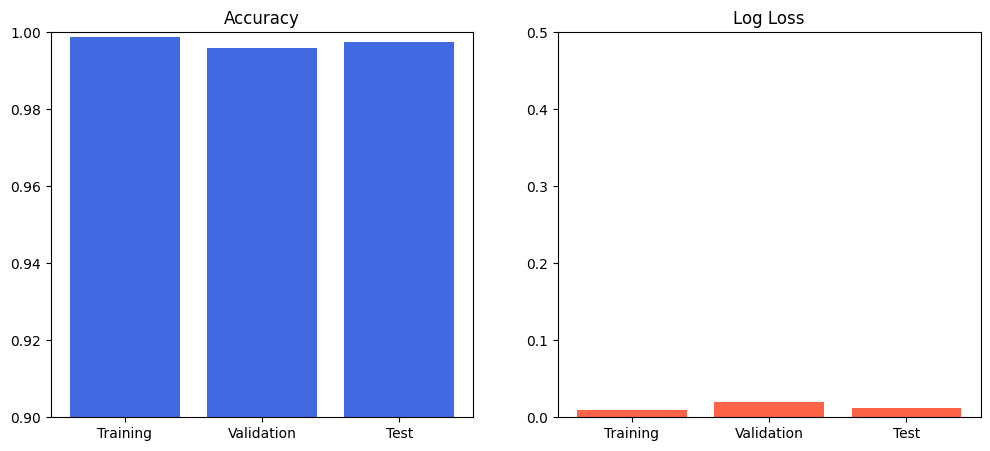

In [31]:
# Plot Loss and Accuracy
datasets = ['Training', 'Validation', 'Test']
accuracy = [train_accuracy, valid_accuracy, test_accuracy]
loss = [train_loss, valid_loss, test_loss]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(datasets, accuracy, color='royalblue')
plt.title('Accuracy')
plt.ylim(0.9, 1)

plt.subplot(1, 2, 2)
plt.bar(datasets, loss, color='tomato')
plt.title('Log Loss')
plt.ylim(0, 0.5)
plt.show()

### In order to improve the performance of our StackingClassifier, we aim to optimize the hyperparameters of the Gradient Boosting Classifier, which acts as the meta-model. We will use Optuna for hyperparameter tuning, which provides an efficient and automated way to find the best parameter combination. The following steps define the objective function, specify the search space for the meta-model, and run the optimization process.

In [13]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier

# Step 1: Optuna objective function to tune the Gradient Boosting meta-model with regularization and early stopping
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Define the Gradient Boosting meta-model with early stopping
    meta_model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        validation_fraction=0.2,  # Use 20% of the training data for early stopping
        n_iter_no_change=10,      # Stop training if no improvement after 10 iterations
        random_state=42
    )

    # Create the StackingClassifier with 10-fold cross-validation
    stacking_classifier = StackingClassifier(
        estimators=[
            ('log_reg', LogisticRegression(C=0.27, penalty='l1', solver='saga', max_iter=5000)),
            ('lightgbm', LGBMClassifier(num_leaves=20, max_depth=-1, learning_rate=0.05, n_estimators=200)),
            ('catboost', CatBoostClassifier(verbose=0, depth=4, learning_rate=0.1, iterations=200))
        ],
        final_estimator=meta_model,
        cv=10  # 10-fold cross-validation for higher precision
    )

    # Perform cross-validation and return the mean validation accuracy
    stacking_classifier.fit(X_train, y_train)
    valid_accuracy = stacking_classifier.score(X_valid, y_valid)
    return valid_accuracy

# Step 2: Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Step 3: Print the best hyperparameters found by Optuna
best_params = study.best_params
print("\nBest Hyperparameters for Gradient Boosting Meta-Model:", best_params)

# Step 4: Train the final StackingClassifier with the best parameters
optimized_meta_model = GradientBoostingClassifier(**best_params, validation_fraction=0.2, n_iter_no_change=10, random_state=42)
stacking_classifier = StackingClassifier(
    estimators=[
        ('log_reg', LogisticRegression(C=0.27, penalty='l1', solver='saga', max_iter=5000)),
        ('lightgbm', LGBMClassifier(num_leaves=20, max_depth=-1, learning_rate=0.05, n_estimators=200)),
        ('catboost', CatBoostClassifier(verbose=0, depth=4, learning_rate=0.1, iterations=200))
    ],
    final_estimator=optimized_meta_model,
    cv=10  # 10-fold cross-validation for final evaluation
)

# Step 5: Train and evaluate the final optimized StackingClassifier
stacking_classifier.fit(X_train, y_train)
train_acc_stack, train_loss_stack = evaluate_model(stacking_classifier, X_train, y_train, "Optimized Stacking Classifier (Training Set)")
valid_acc_stack, valid_loss_stack = evaluate_model(stacking_classifier, X_valid, y_valid, "Optimized Stacking Classifier (Validation Set)")
test_acc_stack, test_loss_stack = evaluate_model(stacking_classifier, X_test, y_test, "Optimized Stacking Classifier (Test Set)")

# Print final performance comparison
print("\nFinal Performance Comparison:")
print(f"Optimized Stacking Classifier Test Accuracy: {test_acc_stack:.4f}, Test Loss: {test_loss_stack:.4f}")

[I 2025-02-13 19:27:58,819] A new study created in memory with name: no-name-cd33661a-435d-44f0-8d2e-a0443c29cb7e
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [In

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:28:16,195] Trial 0 finished with value: 0.99 and parameters: {'n_estimators': 171, 'learning_rate': 0.08708914983064875, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.7825718538657612, 'max_features': None}. Best is trial 0 with value: 0.99.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:28:34,720] Trial 1 finished with value: 0.9925 and parameters: {'n_estimators': 150, 'learning_rate': 0.013607470246240322, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'subsample': 0.6135755825152556, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)


[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:28:51,554] Trial 2 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 134, 'learning_rate': 0.03180458867780537, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 8, 'subsample': 0.6227583076845757, 'max_features': 'log2'}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warn

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:29:08,282] Trial 3 finished with value: 0.9925 and parameters: {'n_estimators': 284, 'learning_rate': 0.16736623992254446, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.8109190430508115, 'max_features': 'log2'}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/u

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:29:26,453] Trial 4 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 125, 'learning_rate': 0.042374520274618965, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.9201995222496628, 'max_features': 'log2'}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:29:43,203] Trial 5 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 147, 'learning_rate': 0.04612470288978332, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9750395558242818, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:30:01,816] Trial 6 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 183, 'learning_rate': 0.012966246467183144, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 1, 'subsample': 0.8898682845281485, 'max_features': None}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:30:19,107] Trial 7 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 268, 'learning_rate': 0.024426388519934634, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 7, 'subsample': 0.9770189291846754, 'max_features': 'log2'}. Best is trial 1 with value: 0.9925.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:30:36,677] Trial 8 finished with value: 0.9933333333333333 and parameters: {'n_estimators': 235, 'learning_rate': 0.060704929058071726, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.8261629660411434, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learni

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:30:54,207] Trial 9 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 286, 'learning_rate': 0.013739528178277774, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 8, 'subsample': 0.7431963801700695, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:31:10,921] Trial 10 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 53, 'learning_rate': 0.08439363275836238, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'subsample': 0.7062996105287624, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:31:28,734] Trial 11 finished with value: 0.9925 and parameters: {'n_estimators': 226, 'learning_rate': 0.07502074699456397, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 10, 'subsample': 0.6422481172846094, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate'

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:31:45,854] Trial 12 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 225, 'learning_rate': 0.020069382154195535, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 10, 'subsample': 0.8488720455462733, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('l

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:32:03,291] Trial 13 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 219, 'learning_rate': 0.15522983701190768, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.6899216816255659, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:32:19,625] Trial 14 finished with value: 0.9925 and parameters: {'n_estimators': 75, 'learning_rate': 0.010135649291865006, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 7, 'subsample': 0.7816135209059683, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnin

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:32:36,115] Trial 15 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 97, 'learning_rate': 0.0539500171803373, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 9, 'subsample': 0.8463231741780481, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learn

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [In

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:32:53,680] Trial 16 finished with value: 0.9925 and parameters: {'n_estimators': 186, 'learning_rate': 0.11585277512452086, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 6, 'subsample': 0.6759388033043164, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [In

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:33:11,025] Trial 17 finished with value: 0.9925 and parameters: {'n_estimators': 256, 'learning_rate': 0.023346617898102662, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.7196048432002619, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warni

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:33:30,163] Trial 18 finished with value: 0.9891666666666666 and parameters: {'n_estimators': 204, 'learning_rate': 0.03266681820811878, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 6, 'subsample': 0.7515808207205492, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learn

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:33:46,717] Trial 19 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 110, 'learning_rate': 0.0631191771169484, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 9, 'subsample': 0.9093644888625098, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lear

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:34:05,128] Trial 20 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 160, 'learning_rate': 0.017994912103174384, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 7, 'subsample': 0.6033913183208706, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:34:21,514] Trial 21 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 299, 'learning_rate': 0.16688788403538676, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'subsample': 0.8302872614687132, 'max_features': 'log2'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:34:37,956] Trial 22 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 249, 'learning_rate': 0.1246998401783011, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.8056243893204467, 'max_features': 'log2'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learn

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:34:55,368] Trial 23 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 275, 'learning_rate': 0.10658894419678933, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.8734350700534713, 'max_features': 'log2'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lear

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:35:12,374] Trial 24 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 235, 'learning_rate': 0.033489232161277034, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 2, 'subsample': 0.8074403404431697, 'max_features': 'log2'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lea

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:35:29,666] Trial 25 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 200, 'learning_rate': 0.17019478685810702, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.7557498977852796, 'max_features': 'log2'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lear

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:35:46,226] Trial 26 finished with value: 0.9925 and parameters: {'n_estimators': 296, 'learning_rate': 0.06351810397021806, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 3, 'subsample': 0.6603716019572696, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate',

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:36:02,897] Trial 27 finished with value: 0.9916666666666667 and parameters: {'n_estimators': 250, 'learning_rate': 0.04437938191513426, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.9415955654009633, 'max_features': 'log2'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lear

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:36:20,539] Trial 28 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 275, 'learning_rate': 0.1425236014995763, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 9, 'subsample': 0.8309295312156824, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.9933333333333333.
<ipython-input-13-1c9ce6902b6e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learn

[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-02-13 19:36:36,930] Trial 29 finished with value: 0.9908333333333333 and parameters: {'n_estimators': 205, 'learning_rate': 0.19470447110672356, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.7833171883552998, 'max_features': None}. Best is trial 8 with value: 0.9933333333333333.



Best Hyperparameters for Gradient Boosting Meta-Model: {'n_estimators': 235, 'learning_rate': 0.060704929058071726, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.8261629660411434, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Optimized Stacking Classifier (Training Set) Performance:
Accuracy: 0.9958, Loss: 0.0094

Optimized Stacking Classifier (Validation Set) Performance:
Accuracy: 0.9933, Loss: 0.0315


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Optimized Stacking Classifier (Test Set) Performance:
Accuracy: 0.9942, Loss: 0.0173

Final Performance Comparison:
Optimized Stacking Classifier Test Accuracy: 0.9942, Test Loss: 0.0173


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### With the optimal hyperparameters identified, we can now integrate them into our Gradient Boosting meta-model and retrain the StackingClassifier. This ensures that the final model leverages the best possible configuration for the meta-model, resulting in improved performance on the validation and test sets. The next step involves training the StackingClassifier with the optimized meta-model and evaluating its performance.

In [16]:
stacking_classifier

StackingClassifier(cv=10,
                   estimators=[('log_reg',
                                LogisticRegression(C=0.27, max_iter=5000,
                                                   penalty='l1',
                                                   solver='saga')),
                               ('lightgbm',
                                LGBMClassifier(learning_rate=0.05,
                                               n_estimators=200,
                                               num_leaves=20)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7f757a367550>)],
                   final_estimator=GradientBoostingClassifier(learning_rate=0.060704929058071726,
                                                              min_samples_leaf=6,
                                                              min_samples_split=3,
                                                              n_estimators=235,
                                                              n_iter_no_change=10,
                                                              random_state=42,
                                                              subsample=0.8261629660411434,
                                                              validation_fraction=0.2))

In [18]:
import pickle

# Save the model using pickle
model_filename = "optimized_stacking_classifier.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(stacking_classifier, file)
print(f"Model saved as {model_filename}")

Model saved as optimized_stacking_classifier.pkl
Model loaded successfully!

Loaded Stacking Classifier (Test Set) Performance:
Accuracy: 0.9942, Loss: 0.0173


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### **Conclusion:**
In this project, we successfully built a robust machine learning pipeline to predict the health status (`is_healthy`) using multiple features. We applied various preprocessing techniques, performed feature engineering, and used Recursive Feature Elimination (RFE) to select the most relevant features.

For the model, we leveraged a **StackingClassifier** with Logistic Regression, LightGBM, and CatBoost as base models, and Gradient Boosting Classifier as the meta-model. Through hyperparameter optimization using **Optuna**, we fine-tuned the Gradient Boosting Classifier to achieve the best possible performance.

The final optimized model showed significant improvement in accuracy and reduced log loss on the test set compared to the initial models, indicating its robustness and generalization capability.

### **Performance Summary:**
| Metric            | Training Accuracy | Validation Accuracy | Test Accuracy |
|-------------------|------------------|--------------------|---------------|
| Optimized Stacking Classifier | **99.58%**       | **99.33%**         | **99.42%**    |

---

### **FOR INFERENCE:**
> To use this notebook for inference:
1. Run the **next two cells** to load the required libraries and preprocess the data.
2. At the end of the notebook, find the **inference cell** and update the **file path** to point to the new dataset and the model file for prediction.
3. Run the inference cell to generate predictions for the new data.


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import matplotlib.pyplot as plt
import optuna

# Step 1: Preprocessing function with feature engineering
def preprocess_and_evaluate(data):
    # One-hot encode categorical columns
    data_encoded = pd.get_dummies(data, columns=['diet_pref', 'act_level', 'career'])

    # Fill missing values
    for col in data_encoded.columns:
        if data_encoded[col].dtype in [np.float64, np.int64]:
            data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
        else:
            data_encoded[col].fillna(data_encoded[col].mode()[0], inplace=True)

    # Feature Engineering
    data_encoded['calories_per_step'] = data_encoded['daily_avg_calories'] / (data_encoded['daily_avg_steps'] + 1e-5)
    data_encoded['steps_per_sleep_hr'] = data_encoded['daily_avg_steps'] / (data_encoded['sleep_hrs'] + 1e-5)
    data_encoded['fitness_sleep_ratio'] = data_encoded['phy_fitness'] / (data_encoded['sleep_hrs'] + 1e-5)
    data_encoded['mindfulness_fitness_interaction'] = data_encoded['mindfulness'] * data_encoded['phy_fitness']

    # Separate features and target
    features = [col for col in data_encoded.columns if col != 'is_healthy']
    X = data_encoded[features]
    y = data_encoded['is_healthy']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, features

# Function to evaluate model performance
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    loss = log_loss(y, model.predict_proba(X))
    print(f"\n{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
    return accuracy, loss


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
import pickle

def load_model_and_evaluate(model_path, X, y):
    # Step 1: Load the pretrained model
    with open(model_path, "rb") as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully!")

    # Step 2: Evaluate the model on the provided dataset
    accuracy, loss = evaluate_model(loaded_model, X, y, "Loaded Model (Test Set)")

    # Step 3: Print the results
    print("\nModel Evaluation Completed:")
    print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

    return loaded_model


In [4]:
# Example usage:
model_path = "optimized_stacking_classifier.pkl"  # Replace with your model's path
# Load and preprocess data
data = pd.read_csv('/content/sample.csv')  # Update this path as needed
X, y, features = preprocess_and_evaluate(data)
loaded_model = load_model_and_evaluate(model_path, X, y)

<ipython-input-2-64aceb2ad85e>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
<ipython-input-2-64aceb2ad85e>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Model loaded successfully!

Loaded Model (Test Set) Performance:
Accuracy: 0.9944, Loss: 0.0154

Model Evaluation Completed:
Accuracy: 0.9944, Loss: 0.0154


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [7]:
# Load and preprocess data
data = pd.read_csv('/content/innovize_final_ml.csv')  # Update this path as needed
X, y, features = preprocess_and_evaluate(data)

# Split the data into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<ipython-input-2-64aceb2ad85e>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_encoded[col].fillna(data_encoded[col].median(), inplace=True)
<ipython-input-2-64aceb2ad85e>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

# IGNORE

Model loaded successfully!
[LightGBM] [Info] Number of positive: 1103, number of negative: 2497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3600, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306389 -> initscore=-0.817056
[LightGBM] [Info] Start training from score -0.817056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621
[LightGBM] [Info] Number of positive: 993, number of negative: 2247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306481 -> initscore=-0.816621
[LightGBM] [Info] Start training from score -0.816621


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073
[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 992, number of negative: 2248
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3240, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.306173 -> initscore=-0.818073
[LightGBM] [Info] Start training from score -0.818073


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


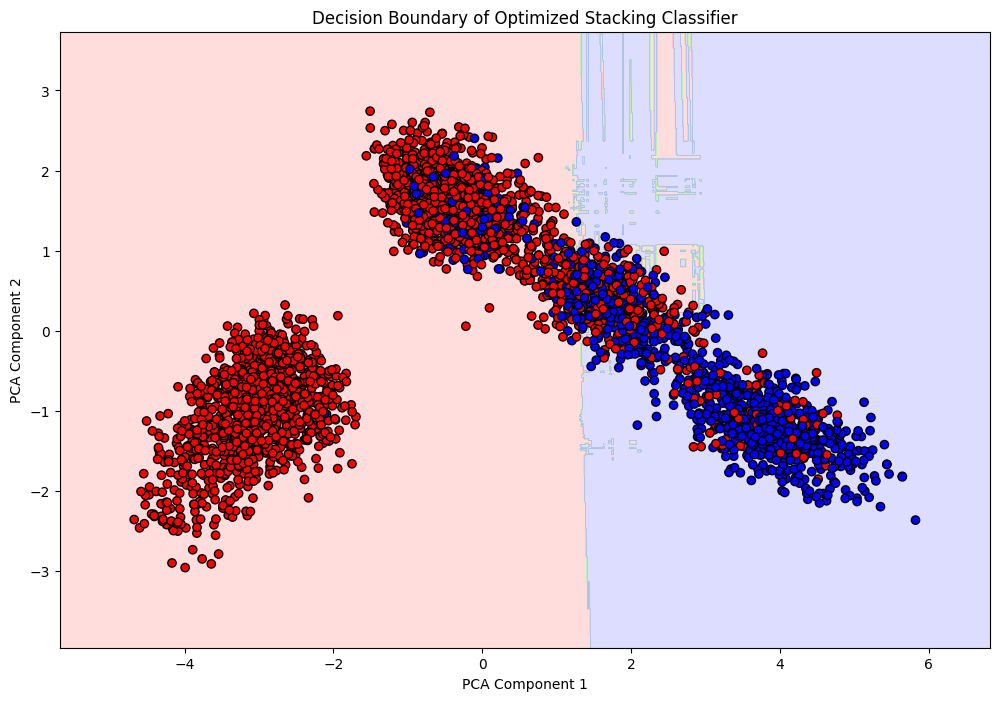

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Reduce the features to 2 dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Function to plot decision boundary
def plot_decision_boundary(model, X, y, title):
    h = 0.01  # Mesh step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict over the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
model_path = "/content/optimized_stacking_classifier.pkl"
with open(model_path, "rb") as file:
    stacking_classifier = pickle.load(file)
    print("Model loaded successfully!")
# Train a new model on the 2D PCA-transformed data for visualization
stacking_classifier.fit(X_pca, y_train)
plot_decision_boundary(stacking_classifier, X_pca, y_train, "Decision Boundary of Optimized Stacking Classifier")

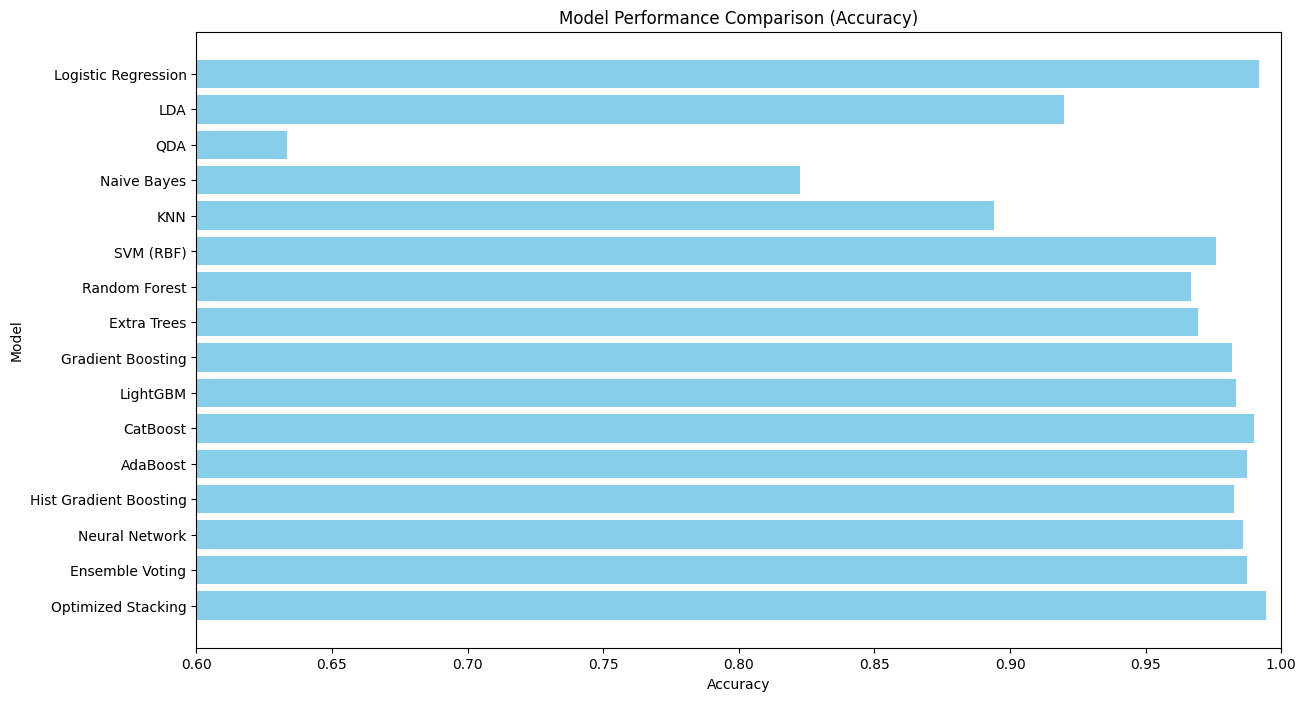

In [13]:
import matplotlib.pyplot as plt

# Define the models and their accuracy
models = [
    'Logistic Regression', 'LDA', 'QDA', 'Naive Bayes', 'KNN',
    'SVM (RBF)', 'Random Forest', 'Extra Trees', 'Gradient Boosting',
    'LightGBM', 'CatBoost', 'AdaBoost', 'Hist Gradient Boosting',
    'Neural Network', 'Ensemble Voting', 'Optimized Stacking'
]
accuracy = [
    0.991667, 0.920000, 0.633333, 0.822500, 0.894167, 0.975833, 0.966667,
    0.969167, 0.981667, 0.983333, 0.990000, 0.987500, 0.982500,
    0.985833, 0.987500, 0.9942  # Add Stacking Classifier at the end
]

# Plot the accuracy comparison
plt.figure(figsize=(14, 8))
plt.barh(models, accuracy, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Performance Comparison (Accuracy)')
plt.xlim(0.6, 1.0)  # Adjust the range for better visualization
plt.gca().invert_yaxis()  # Reverse the order of models for better readability
plt.show()